In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
!pip install monai
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    Compose,
    SaveImaged,
    ScaleIntensityRanged,
    Invertd,
    MapTransform,
    apply_transform,
 RandAffined,
 Activations,
 ToTensord,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate


# import random
from scipy.ndimage import affine_transform

from math import cos, sin, radians
from math import pi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=0215aa73a8728d78fdea31f9c88d4e3ec3ed07c6cedc9b2b7ec7cc46257b38a2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=afd6313ccec218baae32a52616ba5ef055d903bf2af5329679ca0e21406e51c4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/ICH seg/ICH dataset"

### Load data

In [ ]:
images = sorted(glob.glob(os.path.join(root_dir, "ct_scans", "*.nii")))
labels = sorted(glob.glob(os.path.join(root_dir, "masks", "*.nii")))

In [ ]:
def load_data2D(images, labels, target_size=(256, 256), slice_axis=2):
    """
    Load and resize 2D slices from 3D images and masks
    """
    data_dicts = []

    for image_name, label_name in zip(images, labels):
        image_data = nib.load(image_name).get_fdata()
        label_data = nib.load(label_name).get_fdata()

        # Extract and resize 2D slices along the specified axis
        for i in range(image_data.shape[slice_axis]):
            image_slice_raw = cv2.resize(image_data[:,:,i], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            label_slice = cv2.resize(label_data[:,:,i], dsize=target_size, interpolation=cv2.INTER_NEAREST)

            # Duplicate the single channel to create a 3-channel image
            image_slice = cv2.merge([image_slice_raw, image_slice_raw, image_slice_raw])

            # Add channel dimension as the first dimension
            image_slice = np.moveaxis(image_slice, -1, 0)
            label_slice = np.expand_dims(label_slice, axis=0)

            # Create a dictionary for each pair of resized 2D image and label slices
            data_dicts.append({"image": image_slice, "label": label_slice})

    return data_dicts

In [ ]:
data_dicts = load_data2D(images, labels)

In [ ]:
data_dicts[0]["image"].shape, data_dicts[0]["label"].shape

((3, 256, 256), (1, 256, 256))

In [ ]:
def extract_pos_slice(data_dicts):
    """
    Extract positive slices from data
    """
    pos_data_dicts = []
    for data_dict in data_dicts:
        if np.sum(data_dict["label"]) > 0:
            pos_data_dicts.append(data_dict)
    return pos_data_dicts

In [ ]:
def window_transform(data_dicts, window_centers, window_widths):
    """
    Apply different window transformation to create 3 channel images
    Convert label to binary
    """
    for data_dict in data_dicts:
        image, label = data_dict["image"], data_dict["label"]

        # Apply intensity windowing to each channel separately
        for i in range(image.shape[0]):
            window_center = window_centers[i]
            window_width = window_widths[i]

            # Clip and normalize each channel
            image[i] = np.clip(image[i], window_center - window_width // 2, window_center + window_width // 2)
            image[i] = (image[i] - (window_center - window_width // 2)) / window_width

        # Convert label to binary 0 or 1
        label = np.where(label > 0, 1, 0)

        data_dict["image"], data_dict["label"] = image, label
    return data_dicts


In [ ]:
data = window_transform(data_dicts, [40, 100, 400], [120, 200, 1800])

In [ ]:
# shuffle the data
import random
random.seed(42)
random.shuffle(data)

In [ ]:
len(data)

2814

In [ ]:
# split data into train and test set
train_data, test_data = data[:-int(len(data)/5)], data[-int(len(data)/5):]

In [ ]:
data = train_data

# create 5 folds of cross_validation
from sklearn.model_selection import KFold

# Number of folds for cross-validation
num_CV = 5
kf = KFold(n_splits=num_CV, shuffle=True, random_state=42)

# Lists to store training and validation sets for each fold
train_files, val_files = [], []

# Loop through the folds
for train_index, val_index in kf.split(data):

    train_data, val_data = [data[i] for i in train_index], [data[i] for i in val_index]

    # Append the training and validation sets to the lists
    train_files.append(train_data)
    val_files.append(val_data)


In [ ]:
print("number of slices in training set: ", len(train_files[0]))
print("number of slices in validation set: ", len(val_files[0]))
print("number of positive slices in training set:", len(extract_pos_slice(train_files[0])))
print("number of positive slices in validation set:", len(extract_pos_slice(val_files[0])))
print("shape of slice sample", train_files[0][0]["image"].shape)
print("shape of label sample", val_files[0][0]["label"].shape)

number of slices in training set:  1801
number of slices in validation set:  451
number of positive slices in training set: 190
number of positive slices in validation set: 55
shape of slice sample (3, 256, 256)
shape of label sample (1, 256, 256)


In [ ]:
set_determinism(seed=0)

In [ ]:
# Define the parameters for rotation and translation
rotation_angles = [15, 30, 60, 90, 180, 270]
translations = [(0.1, 0.1), (0.1, -0.1), (-0.1, 0.1), (-0.1, -0.1)]

In [ ]:
# Helper function to convert degrees to radians
def deg_to_rad(degrees):
    return degrees * (pi / 180)

In [ ]:
train_transforms_list = []

for angle in rotation_angles:
    for tx, ty in translations:
        train_transforms_list.append(
            RandAffined(
                keys=['image', 'label'],
                mode=('bilinear', 'nearest'),
                prob=0.5,
                spatial_size=(256, 256),
                rotate_range=(0, 0, deg_to_rad(angle)),  # Rotate around z-axis
                translate_range=(tx, ty, 0),  # Translate Tx, Ty
                scale_range=(0.0, 0.0, 0.0),  # No scaling
                padding_mode='border'
            )
        )

# Add the final transformation to convert to tensor
train_transforms_list.append(ToTensord(keys=["image", "label"], dtype=torch.float32))

# Create the compose transform
train_transforms = Compose(train_transforms_list)

In [ ]:
val_transforms = Compose(
    [
        ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [ ]:
# Assuming train_files is defined properly
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)

Loading dataset: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


In [ ]:
# Assuming that train_loader is defined as shown previously

# Initialize a counter for the samples
sample_count = 0

# Iterate through the DataLoader
for batch in train_loader:
    images, labels = batch['image'], batch['label']
    sample_count += images.shape[0]  # Increment by the batch size

print(f"Total number of augmented samples: {sample_count}")

In [ ]:
# check sample from dataset
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

torch.Size([451, 3, 256, 256])
image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


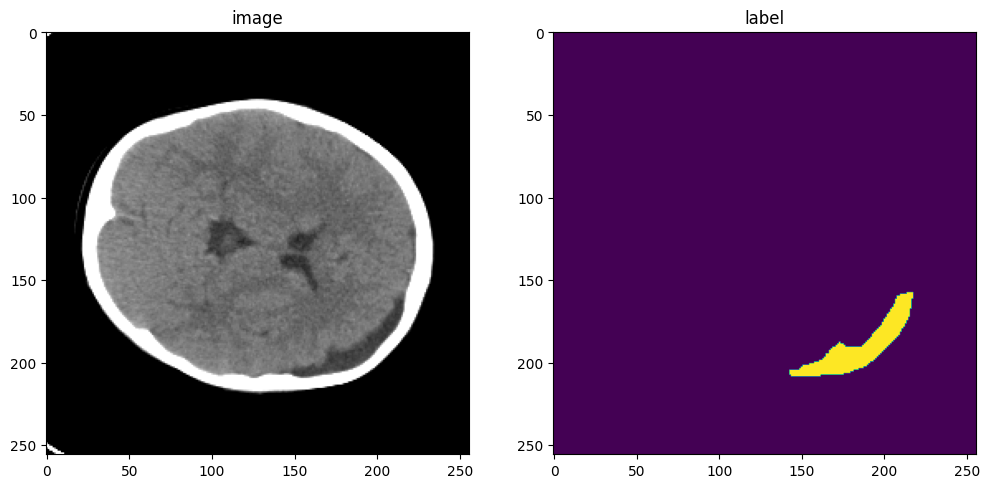

In [ ]:
print(check_data["image"].shape)
image, label = (check_data["image"][125][0], check_data["label"][125][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()

### Training

In [ ]:
device = torch.device("cuda:0")
loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)

model = smp.Unet(
    encoder_name="mit_b5",
    decoder_attention_type="scse",
    in_channels=3,
    classes=1,
    activation='sigmoid',
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b5.pth" to /root/.cache/torch/hub/checkpoints/mit_b5.pth
100%|██████████| 313M/313M [00:01<00:00, 262MB/s]


In [ ]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

num_CV = 5
max_epochs = 100
epoch_per_CV = max_epochs // num_CV

for i in range(num_CV):

    print("-" * 10)
    print(f"Fold {i}")
    train_ds = CacheDataset(data=train_files[i], transform=train_transforms, cache_rate=1.0, num_workers=4)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

    if i < num_CV - 1:
        start_epoch = i * epoch_per_CV
        end_epoch = (i + 1) * epoch_per_CV
    else:
        start_epoch = i * epoch_per_CV
        end_epoch = max_epochs

    for epoch in range(start_epoch, end_epoch):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
        # lr_scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    val_outputs = (val_outputs > 0.5).float()  # Assuming sigmoid activation

                    # Calculate Dice for the batch
                    intersection = torch.sum(val_outputs * val_labels)
                    union = torch.sum(val_outputs) + torch.sum(val_labels) - intersection
                    iou = (intersection + 1e-15) / (union + 1e-15)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
Fold 0


Loading dataset: 100%|██████████| 451/451 [00:00<00:00, 1304.08it/s]


----------
epoch 1/100


Training:   0%|          | 0/57 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 57/57 [01:01<00:00,  1.07s/it]


epoch 1 average loss: 0.9275
----------
epoch 2/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 2 average loss: 0.9788


Validation: 100%|██████████| 57/57 [00:12<00:00,  4.48it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.0027
best mean IoU: 0.0027 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 3 average loss: 0.9430
----------
epoch 4/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 4 average loss: 0.9775


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.0038
best mean IoU: 0.0038 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 5 average loss: 0.9595
----------
epoch 6/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 6 average loss: 0.9415


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.0062
best mean IoU: 0.0062 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 7 average loss: 0.9582
----------
epoch 8/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 8 average loss: 0.9393


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.0213
best mean IoU: 0.0213 at epoch: 8
----------
epoch 9/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 9 average loss: 0.9739
----------
epoch 10/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 10 average loss: 0.9902


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.62it/s]


current epoch: 10 current mean IoU: 0.0138
best mean IoU: 0.0213 at epoch: 8
----------
epoch 11/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 11 average loss: 0.9188
----------
epoch 12/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 12 average loss: 0.9524


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.69it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.0221
best mean IoU: 0.0221 at epoch: 12
----------
epoch 13/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 13 average loss: 0.9685
----------
epoch 14/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 14 average loss: 0.9669


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.62it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.1667
best mean IoU: 0.1667 at epoch: 14
----------
epoch 15/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 15 average loss: 0.9477
----------
epoch 16/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 16 average loss: 0.9463


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.53it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.2506
best mean IoU: 0.2506 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 17 average loss: 0.9264
----------
epoch 18/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 18 average loss: 0.9602


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.51it/s]


current epoch: 18 current mean IoU: 0.1634
best mean IoU: 0.2506 at epoch: 16
----------
epoch 19/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 19 average loss: 0.9760
----------
epoch 20/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 20 average loss: 0.9741


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.2731
best mean IoU: 0.2731 at epoch: 20
----------
Fold 1


Loading dataset: 100%|██████████| 451/451 [00:00<00:00, 1279.59it/s]


----------
epoch 21/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 21 average loss: 0.9561
----------
epoch 22/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 22 average loss: 0.9191


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.3030
best mean IoU: 0.3030 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 23 average loss: 0.9516
----------
epoch 24/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 24 average loss: 0.9323


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


saved new best metric model
current epoch: 24 current mean IoU: 0.5085
best mean IoU: 0.5085 at epoch: 24
----------
epoch 25/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 25 average loss: 0.9468
----------
epoch 26/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 26 average loss: 0.9097


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.53it/s]


saved new best metric model
current epoch: 26 current mean IoU: 0.5474
best mean IoU: 0.5474 at epoch: 26
----------
epoch 27/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 27 average loss: 0.9414
----------
epoch 28/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 28 average loss: 0.9046


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.50it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.5715
best mean IoU: 0.5715 at epoch: 28
----------
epoch 29/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 29 average loss: 0.8845
----------
epoch 30/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 30 average loss: 0.8984


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.48it/s]


current epoch: 30 current mean IoU: 0.5381
best mean IoU: 0.5715 at epoch: 28
----------
epoch 31/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 31 average loss: 0.9306
----------
epoch 32/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 32 average loss: 0.9420


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.48it/s]


current epoch: 32 current mean IoU: 0.5707
best mean IoU: 0.5715 at epoch: 28
----------
epoch 33/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 33 average loss: 0.8867
----------
epoch 34/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 34 average loss: 0.9186


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.43it/s]


current epoch: 34 current mean IoU: 0.5588
best mean IoU: 0.5715 at epoch: 28
----------
epoch 35/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


epoch 35 average loss: 0.8785
----------
epoch 36/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02it/s]


epoch 36 average loss: 0.9075


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.47it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.6025
best mean IoU: 0.6025 at epoch: 36
----------
epoch 37/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.02it/s]


epoch 37 average loss: 0.9068
----------
epoch 38/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02it/s]


epoch 38 average loss: 0.8484


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.45it/s]


current epoch: 38 current mean IoU: 0.5883
best mean IoU: 0.6025 at epoch: 36
----------
epoch 39/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 39 average loss: 0.8928
----------
epoch 40/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 40 average loss: 0.8718


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.52it/s]


saved new best metric model
current epoch: 40 current mean IoU: 0.6056
best mean IoU: 0.6056 at epoch: 40
----------
Fold 2


Loading dataset: 100%|██████████| 450/450 [00:00<00:00, 1312.12it/s]


----------
epoch 41/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/it]


epoch 41 average loss: 0.8716
----------
epoch 42/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 42 average loss: 0.8817


Validation: 100%|██████████| 57/57 [00:11<00:00,  4.87it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.6086
best mean IoU: 0.6086 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 43 average loss: 0.8594
----------
epoch 44/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 44 average loss: 0.8734


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.54it/s]


saved new best metric model
current epoch: 44 current mean IoU: 0.6486
best mean IoU: 0.6486 at epoch: 44
----------
epoch 45/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 45 average loss: 0.8809
----------
epoch 46/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 46 average loss: 0.8525


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


saved new best metric model
current epoch: 46 current mean IoU: 0.6688
best mean IoU: 0.6688 at epoch: 46
----------
epoch 47/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 47 average loss: 0.8474
----------
epoch 48/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 48 average loss: 0.8524


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.47it/s]


saved new best metric model
current epoch: 48 current mean IoU: 0.6958
best mean IoU: 0.6958 at epoch: 48
----------
epoch 49/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 49 average loss: 0.8273
----------
epoch 50/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04it/s]


epoch 50 average loss: 0.8222


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.46it/s]


current epoch: 50 current mean IoU: 0.6707
best mean IoU: 0.6958 at epoch: 48
----------
epoch 51/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 51 average loss: 0.7889
----------
epoch 52/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 52 average loss: 0.7735


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]


saved new best metric model
current epoch: 52 current mean IoU: 0.7363
best mean IoU: 0.7363 at epoch: 52
----------
epoch 53/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 53 average loss: 0.7350
----------
epoch 54/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 54 average loss: 0.7961


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.41it/s]


current epoch: 54 current mean IoU: 0.6937
best mean IoU: 0.7363 at epoch: 52
----------
epoch 55/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 55 average loss: 0.7604
----------
epoch 56/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 56 average loss: 0.7626


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.45it/s]


saved new best metric model
current epoch: 56 current mean IoU: 0.7598
best mean IoU: 0.7598 at epoch: 56
----------
epoch 57/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04it/s]


epoch 57 average loss: 0.7429
----------
epoch 58/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 58 average loss: 0.7376


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


current epoch: 58 current mean IoU: 0.7439
best mean IoU: 0.7598 at epoch: 56
----------
epoch 59/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 59 average loss: 0.7362
----------
epoch 60/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 60 average loss: 0.7205


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


saved new best metric model
current epoch: 60 current mean IoU: 0.7749
best mean IoU: 0.7749 at epoch: 60
----------
Fold 3


Loading dataset: 100%|██████████| 450/450 [00:00<00:00, 1279.83it/s]


----------
epoch 61/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 61 average loss: 0.7045
----------
epoch 62/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 62 average loss: 0.6746


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.44it/s]


current epoch: 62 current mean IoU: 0.7714
best mean IoU: 0.7749 at epoch: 60
----------
epoch 63/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 63 average loss: 0.6746
----------
epoch 64/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04it/s]


epoch 64 average loss: 0.6618


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.37it/s]


saved new best metric model
current epoch: 64 current mean IoU: 0.7750
best mean IoU: 0.7750 at epoch: 64
----------
epoch 65/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 65 average loss: 0.6270
----------
epoch 66/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 66 average loss: 0.5577


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]


current epoch: 66 current mean IoU: 0.7622
best mean IoU: 0.7750 at epoch: 64
----------
epoch 67/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 67 average loss: 0.5461
----------
epoch 68/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 68 average loss: 0.5825


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.46it/s]


saved new best metric model
current epoch: 68 current mean IoU: 0.7843
best mean IoU: 0.7843 at epoch: 68
----------
epoch 69/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 69 average loss: 0.5163
----------
epoch 70/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 70 average loss: 0.5777


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.48it/s]


current epoch: 70 current mean IoU: 0.7727
best mean IoU: 0.7843 at epoch: 68
----------
epoch 71/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 71 average loss: 0.5334
----------
epoch 72/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 72 average loss: 0.5243


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]


saved new best metric model
current epoch: 72 current mean IoU: 0.7868
best mean IoU: 0.7868 at epoch: 72
----------
epoch 73/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 73 average loss: 0.5014
----------
epoch 74/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 74 average loss: 0.5115


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.44it/s]


saved new best metric model
current epoch: 74 current mean IoU: 0.7904
best mean IoU: 0.7904 at epoch: 74
----------
epoch 75/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 75 average loss: 0.4549
----------
epoch 76/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 76 average loss: 0.4117


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.45it/s]


current epoch: 76 current mean IoU: 0.7813
best mean IoU: 0.7904 at epoch: 74
----------
epoch 77/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 77 average loss: 0.4317
----------
epoch 78/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 78 average loss: 0.4202


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.47it/s]


current epoch: 78 current mean IoU: 0.7867
best mean IoU: 0.7904 at epoch: 74
----------
epoch 79/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 79 average loss: 0.4119
----------
epoch 80/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 80 average loss: 0.4341


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.39it/s]


current epoch: 80 current mean IoU: 0.7811
best mean IoU: 0.7904 at epoch: 74
----------
Fold 4


Loading dataset: 100%|██████████| 450/450 [00:00<00:00, 1273.53it/s]


----------
epoch 81/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 81 average loss: 0.4088
----------
epoch 82/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 82 average loss: 0.4503


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.8421
best mean IoU: 0.8421 at epoch: 82
----------
epoch 83/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 83 average loss: 0.3883
----------
epoch 84/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 84 average loss: 0.3930


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.48it/s]


saved new best metric model
current epoch: 84 current mean IoU: 0.8446
best mean IoU: 0.8446 at epoch: 84
----------
epoch 85/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 85 average loss: 0.3825
----------
epoch 86/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 86 average loss: 0.3432


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.36it/s]


saved new best metric model
current epoch: 86 current mean IoU: 0.8590
best mean IoU: 0.8590 at epoch: 86
----------
epoch 87/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 87 average loss: 0.3761
----------
epoch 88/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 88 average loss: 0.3269


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.36it/s]


current epoch: 88 current mean IoU: 0.8528
best mean IoU: 0.8590 at epoch: 86
----------
epoch 89/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 89 average loss: 0.3382
----------
epoch 90/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 90 average loss: 0.3555


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.51it/s]


current epoch: 90 current mean IoU: 0.8452
best mean IoU: 0.8590 at epoch: 86
----------
epoch 91/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 91 average loss: 0.3522
----------
epoch 92/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 92 average loss: 0.2815


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]


current epoch: 92 current mean IoU: 0.8502
best mean IoU: 0.8590 at epoch: 86
----------
epoch 93/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 93 average loss: 0.2707
----------
epoch 94/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


epoch 94 average loss: 0.2879


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.50it/s]


current epoch: 94 current mean IoU: 0.8542
best mean IoU: 0.8590 at epoch: 86
----------
epoch 95/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 95 average loss: 0.2829
----------
epoch 96/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


epoch 96 average loss: 0.2785


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]


current epoch: 96 current mean IoU: 0.8566
best mean IoU: 0.8590 at epoch: 86
----------
epoch 97/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


epoch 97 average loss: 0.2917
----------
epoch 98/100


Training: 100%|██████████| 57/57 [00:52<00:00,  1.08it/s]


epoch 98 average loss: 0.2625


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.50it/s]


current epoch: 98 current mean IoU: 0.8539
best mean IoU: 0.8590 at epoch: 86
----------
epoch 99/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 99 average loss: 0.3072
----------
epoch 100/100


Training: 100%|██████████| 57/57 [00:53<00:00,  1.07it/s]


epoch 100 average loss: 0.2517


Validation: 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]

current epoch: 100 current mean IoU: 0.8573
best mean IoU: 0.8590 at epoch: 86


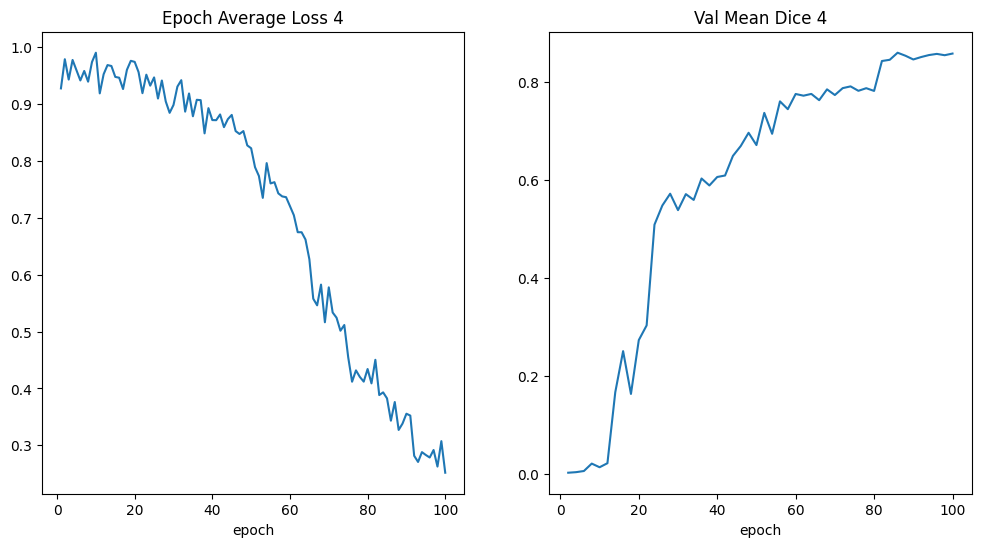

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Epoch Average Loss {i}")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title(f"Val Mean Dice {i}")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
plt.figure("train", (12, 6))

# Plot Epoch Average Loss
plt.subplot(1, 3, 1)
plt.title(f"Epoch Average Loss {i}")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

# Plot Val Mean Dice
plt.subplot(1, 3, 2)
plt.title(f"Val Mean Dice {i}")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)

# Plot Val Mean IoU
plt.subplot(1, 3, 3)
plt.title(f"Val Mean IoU {i}")
x = [val_interval * (i + 1) for i in range(len(iou_metric_values))]
y = iou_metric_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

### Model Evaluation

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64

In [ ]:
device = torch.device("cuda:0")
loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)

model = smp.Unet(
    encoder_name="mit_b5",
    decoder_attention_type="scse",
    in_channels=3,
    classes=1,
    activation='sigmoid',
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

<All keys matched successfully>

In [ ]:
# Count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 84848984


In [ ]:
model_path = os.path.join(root_dir, "best_metric_model.pth")

In [ ]:
# Get the size of the model file
model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
print(f"Model size: {model_size:.2f} MB")

Model size: 324.11 MB


In [ ]:
!pip install ptflops

In [ ]:
from ptflops import get_model_complexity_info

In [ ]:
# Dummy input size (batch size, channels, height, width)
input_size = (3, 256, 256)

# Compute FLOPS and parameters
macs, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)
print(f"FLOPS: {macs}")
print(f"Number of parameters: {params}")

Unet(
  84.85 M, 100.000% Params, 17.69 GMac, 99.829% MACs, 
  (encoder): MixVisionTransformerEncoder(
    81.44 M, 95.986% Params, 14.91 GMac, 84.108% MACs, 
    (patch_embed1): OverlapPatchEmbed(
      9.6 k, 0.011% Params, 39.06 MMac, 0.220% MACs, 
      (proj): Conv2d(9.47 k, 0.011% Params, 38.8 MMac, 0.219% MACs, 3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm(128, 0.000% Params, 262.14 KMac, 0.001% MACs, (64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      74.11 k, 0.087% Params, 75.76 MMac, 0.427% MACs, 
      (proj): Conv2d(73.86 k, 0.087% Params, 75.63 MMac, 0.427% MACs, 64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm(256, 0.000% Params, 131.07 KMac, 0.001% MACs, (128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      369.6 k, 0.436% Params, 94.54 MMac, 0.533% MACs, 
      (proj): Conv2d(368.96 k, 0.435% Params, 94.45 MMac, 0.533

In [ ]:
test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=4)

Loading dataset: 100%|██████████| 562/562 [00:00<00:00, 1323.00it/s]


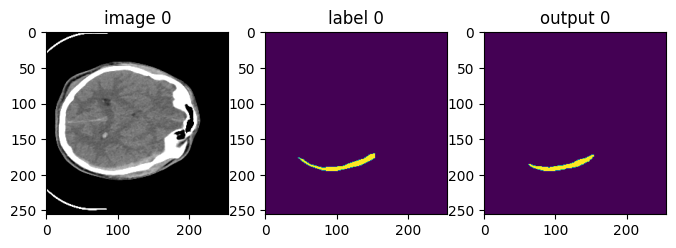

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        roi_size = (256, 256)
        sw_batch_size = 4
        val_outputs = model(val_data["image"].to(device))

        val_outputs = (val_outputs > 0.5).float()

        if np.sum(val_data["label"]) > 10:
            for j in range(val_outputs.shape[0]):
                if np.sum(val_data["label"][j]) > 0:

                    plt.figure("check", (8,6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    plt.imshow(val_data["image"][j, 0, :, :], cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    plt.imshow(val_data["label"][j, 0, :, :])
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    plt.imshow(val_outputs.detach().cpu()[j, 0, :, :])
                    plt.show()
        break